In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, mean_squared_error

In [3]:
# Run the code below if Scikit-learn version is not 1.2.2
print("Scikit-learn Version:", sklearn.__version__)

Scikit-learn Version: 1.2.2


In [ ]:
!pip uninstall scikit-learn
!pip install scikit-learn==1.2.2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Dataset

All the features except longitude and latitude were selected for further analysis.

In [77]:
fuel_density = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/fuelDensity.csv', header=None)
fuel_temp = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/fuelTemp.csv', header=None)
fuel_volume_flow_rate = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/fuelVolumeFlowRate.csv', header=None)

inclinometer = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/inclinometer-raw.csv', header=None)
level_1_median = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/level1median.csv', header=None)
level_2_median = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/level2median.csv', header=None)

longitudinal_water_speed = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/longitudinalWaterSpeed.csv', header=None)
speed_kmh = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/speedKmh.csv', header=None)
speed_knots = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/speedKnots.csv', header=None)

port_pitch = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/portPitch.csv', header=None)
port_rudder = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/portRudder.csv', header=None)
starboard_pitch = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/starboardPitch.csv', header=None)
starboard_rudder = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/starboardRudder.csv', header=None)

track_degree_magnetic = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/trackDegreeMagnetic.csv', header=None)
track_degree_true = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/trackDegreeTrue.csv', header=None)

true_heading = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/trueHeading.csv', header=None)
wind_angle = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/windAngle.csv', header=None)
wind_speed = pd.read_csv('/content/drive/MyDrive/Machine Learning/MP1/windSpeed.csv', header=None)

In [78]:
dataset_dict = {
    "fuel_density": fuel_density,
    "fuel_temp": fuel_temp,
    "fuel_volume_flow_rate": fuel_volume_flow_rate,
    "inclinometer": inclinometer,
    "level_1_median": level_1_median,
    "level_2_median": level_2_median,
    "longitudinal_water_speed": longitudinal_water_speed,
    "speed_kmh": speed_kmh,
    "speed_knots": speed_knots,
    "port_pitch": port_pitch,
    "port_rudder": port_rudder,
    "starboard_pitch": starboard_pitch,
    "starboard_rudder": starboard_rudder,
    "track_degree_magnetic": track_degree_magnetic,
    "track_degree_true": track_degree_true,
    "true_heading": true_heading,
    "wind_angle": wind_angle,
    "wind_speed": wind_speed
}

In [79]:
for key, value in dataset_dict.items():
    print(f"{key}: {value.shape}")

fuel_density: (1627324, 2)
fuel_temp: (1627324, 2)
fuel_volume_flow_rate: (1627324, 2)
inclinometer: (3559677, 2)
level_1_median: (3979774, 2)
level_2_median: (3840794, 2)
longitudinal_water_speed: (548292, 2)
speed_kmh: (1766906, 2)
speed_knots: (1766908, 2)
port_pitch: (1726076, 2)
port_rudder: (1726076, 2)
starboard_pitch: (1726076, 2)
starboard_rudder: (1726076, 2)
track_degree_magnetic: (1766474, 2)
track_degree_true: (1766479, 2)
true_heading: (1439539, 2)
wind_angle: (863755, 2)
wind_speed: (863755, 2)


# Exploring Sampling Rate & Data Granularity

## Key Observations and Interval Selection for Fuel Consumption Analysis
Based on considerations, I have selected **2 minutes** interval as the optimal choice. This interval effectively balances computational feasibility, data clarity, and operational relevance, allowing for voyage-level monitoring and performance analysis without losing critical trends in fuel consumption.

In [80]:
temp = fuel_volume_flow_rate.copy()
temp['Timestamp'] = pd.to_datetime(temp[0], origin='unix', unit='ns', errors='coerce')
temp['TimeDifference'] = temp['Timestamp'].diff().dt.total_seconds()
temp = temp.dropna()

print("Basic Statistics of Time Differences:")
print(temp['TimeDifference'].describe())

print("\nUnique Time Intervals:")
print(temp['TimeDifference'].value_counts())

Basic Statistics of Time Differences:
count    1.627323e+06
mean     2.945761e-02
std      2.515761e+00
min      1.019278e-02
25%      1.021377e-02
50%      1.022348e-02
75%      1.022428e-02
max      1.248763e+03
Name: TimeDifference, dtype: float64

Unique Time Intervals:
TimeDifference
0.010214    9258
0.010214    8961
0.010224    8932
0.010224    8906
0.010214    8873
            ... 
0.010302       1
0.010316       1
0.010302       1
0.010311       1
0.153337       1
Name: count, Length: 11308, dtype: int64


# Resample and Merge Minute Datasets

In [81]:
def resample(df, name):
    df.columns = ['Timestamp', name]
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], origin='unix', unit='ns', errors='coerce')
    df.set_index("Timestamp", inplace=True)
    df_resampled = df.resample("2T").mean()
    return df_resampled

In [ ]:
for key, value in dataset_dict.items():
    dataset_dict[key] = resample(value, key)

In [84]:
dataset = pd.concat(dataset_dict.values(), axis=1, join="outer")
dataset = dataset.interpolate(method = 'linear')
dataset.reset_index(inplace=True)
dataset["Timestamp"] = pd.to_datetime(dataset["Timestamp"])

dataset["EC"] = (dataset["fuel_density"] * dataset["fuel_volume_flow_rate"] * 120) / 1000

pwd = "/content/drive/MyDrive/Machine Learning/MP1/"
dataset.to_csv(f"{pwd}/merged_minute_data.csv", index=False)

In [85]:
pwd = "/content/drive/MyDrive/Machine Learning/MP1/"
dataset = pd.read_csv(f"{pwd}merged_minute_data.csv")
dataset.head()

,Timestamp,fuel_density,fuel_temp,fuel_volume_flow_rate,inclinometer,level_1_median,level_2_median,longitudinal_water_speed,speed_kmh,speed_knots,port_pitch,port_rudder,starboard_pitch,starboard_rudder,track_degree_magnetic,track_degree_true,true_heading,wind_angle,wind_speed,EC
0,1990-02-03 04:08:00,NaN,NaN,NaN,357.248841,16.697194,14.472677,17.157768,33.228449,17.939998,7.202141,-0.398302,7.138903,0.260561,150.296836,146.928099,146.433951,76.486849,9.086775,NaN
1,1990-02-03 04:10:00,NaN,NaN,NaN,357.231625,16.689227,14.633676,17.426928,32.541945,17.572494,7.023658,-0.289722,7.531789,0.020841,127.419157,120.670633,123.292480,166.862264,12.407631,NaN
2,1990-02-03 04:12:00,NaN,NaN,NaN,357.212859,16.714472,14.651350,15.097679,27.028402,14.593414,5.769141,-0.992781,6.382291,0.832864,279.186232,276.047456,251.470146,61.611396,11.848464,NaN
3,1990-02-03 04:14:00,NaN,NaN,NaN,357.286138,16.880850,14.326249,16.365756,31.051226,16.764983,6.327236,-0.324976,7.488221,0.017025,177.477777,170.722280,175.689722,257.974896,16.357946,NaN
4,1990-02-03 04:16:00,NaN,NaN,NaN,357.257330,16.856972,14.491797,16.583184,32.533580,17.567759,6.418378,-0.359607,7.466489,0.212265,167.301211,161.449111,166.467557,167.134615,17.011676,NaN


### Exploratory Data Analysis

## EC
The histogram shows that EC is skewed and also has outliers.

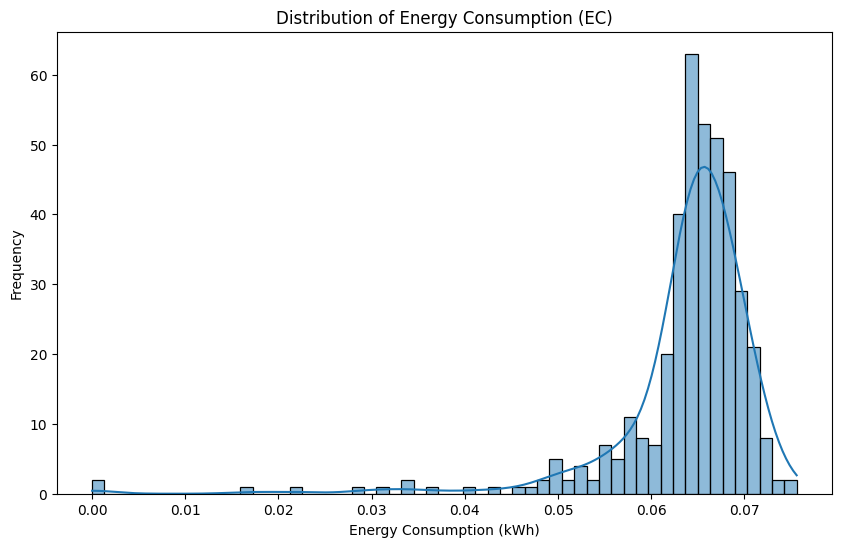

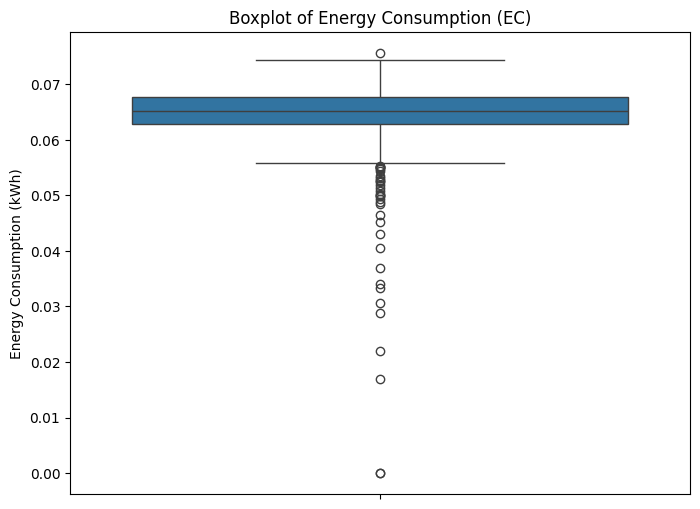

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(dataset['EC'], kde=True)
plt.title('Distribution of Energy Consumption (EC)')
plt.xlabel('Energy Consumption (kWh)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(y=dataset['EC'])
plt.title('Boxplot of Energy Consumption (EC)')
plt.ylabel('Energy Consumption (kWh)')
plt.show()

### Fuel Density, Fuel Temperature, and Flow Rate
Each of the features have some outliers. In addition, fuel density and flow rate distribution is skewed.

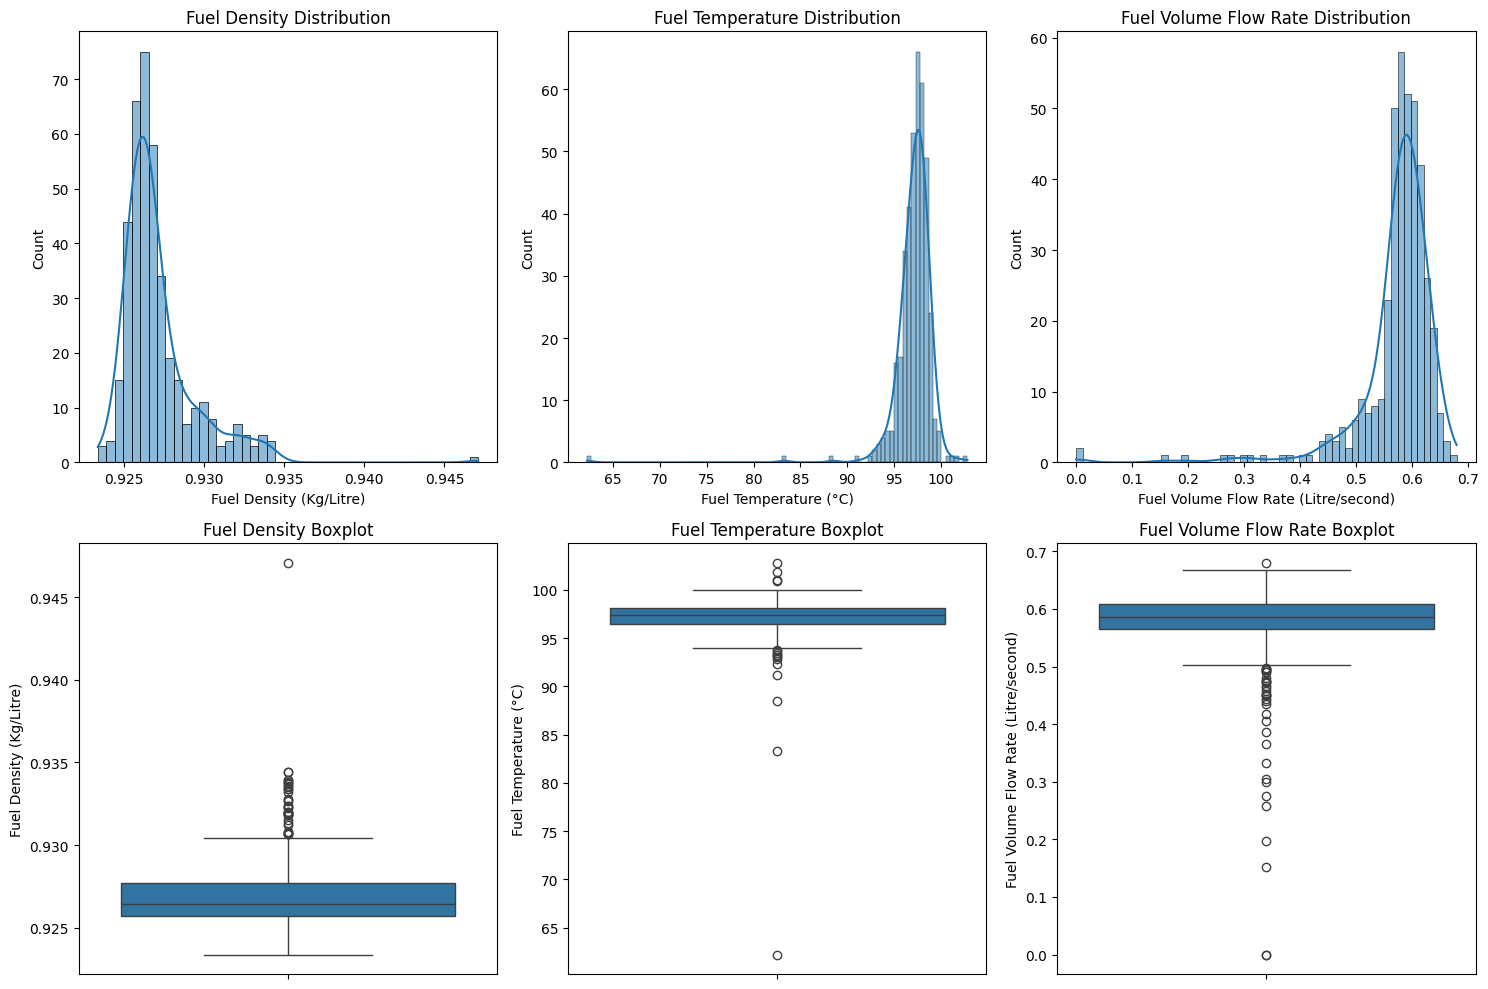

In [87]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

sns.histplot(dataset['fuel_density'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Fuel Density Distribution')
axes[0, 0].set_xlabel('Fuel Density (Kg/Litre)')

sns.histplot(dataset['fuel_temp'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Fuel Temperature Distribution')
axes[0, 1].set_xlabel('Fuel Temperature (°C)')

sns.histplot(dataset['fuel_volume_flow_rate'], kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Fuel Volume Flow Rate Distribution')
axes[0, 2].set_xlabel('Fuel Volume Flow Rate (Litre/second)')

sns.boxplot(y=dataset['fuel_density'], ax=axes[1, 0])
axes[1, 0].set_title('Fuel Density Boxplot')
axes[1, 0].set_ylabel('Fuel Density (Kg/Litre)')

sns.boxplot(y=dataset['fuel_temp'], ax=axes[1, 1])
axes[1, 1].set_title('Fuel Temperature Boxplot')
axes[1, 1].set_ylabel('Fuel Temperature (°C)')

sns.boxplot(y=dataset['fuel_volume_flow_rate'], ax=axes[1, 2])
axes[1, 2].set_title('Fuel Volume Flow Rate Boxplot')
axes[1, 2].set_ylabel('Fuel Volume Flow Rate (Litre/second)')

plt.tight_layout()
plt.show()

### Inclinometer and Water Levels
These features seem to be normally distributed, and might not need any further preprocessing.

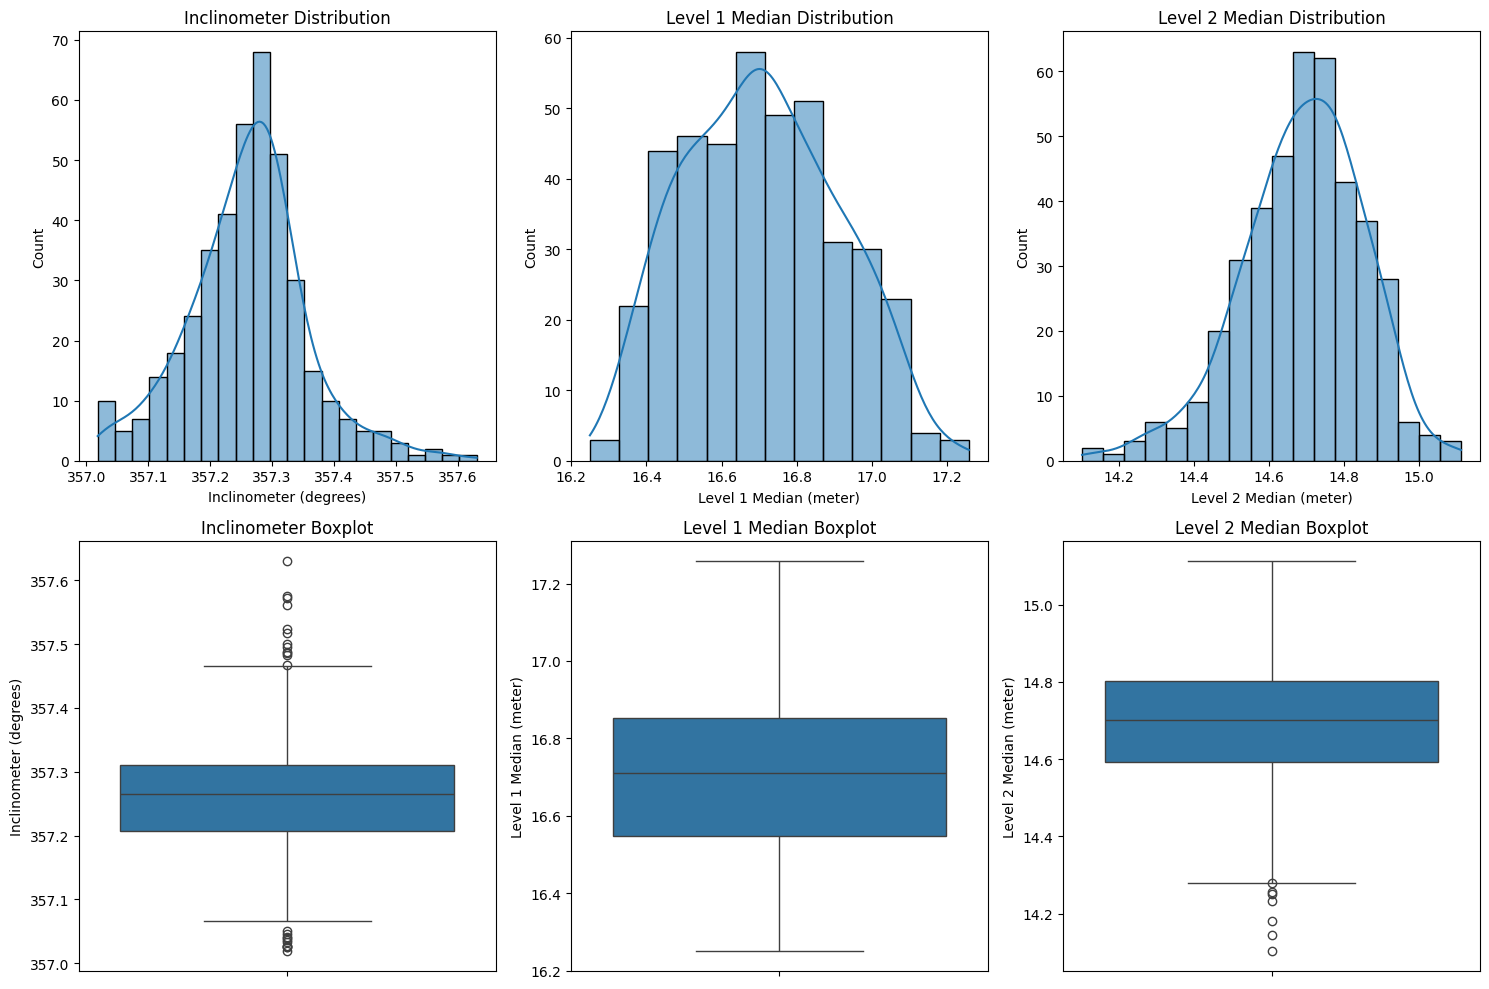

In [88]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

sns.histplot(dataset['inclinometer'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Inclinometer Distribution')
axes[0, 0].set_xlabel('Inclinometer (degrees)')

sns.histplot(dataset['level_1_median'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Level 1 Median Distribution')
axes[0, 1].set_xlabel('Level 1 Median (meter)')

sns.histplot(dataset['level_2_median'], kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Level 2 Median Distribution')
axes[0, 2].set_xlabel('Level 2 Median (meter)')

sns.boxplot(y=dataset['inclinometer'], ax=axes[1, 0])
axes[1, 0].set_title('Inclinometer Boxplot')
axes[1, 0].set_ylabel('Inclinometer (degrees)')

sns.boxplot(y=dataset['level_1_median'], ax=axes[1, 1])
axes[1, 1].set_title('Level 1 Median Boxplot')
axes[1, 1].set_ylabel('Level 1 Median (meter)')

sns.boxplot(y=dataset['level_2_median'], ax=axes[1, 2])
axes[1, 2].set_title('Level 2 Median Boxplot')
axes[1, 2].set_ylabel('Level 2 Median (meter)')

plt.tight_layout()
plt.show()

### Speeds
Both water and groud speed features seem to be normally distributed.

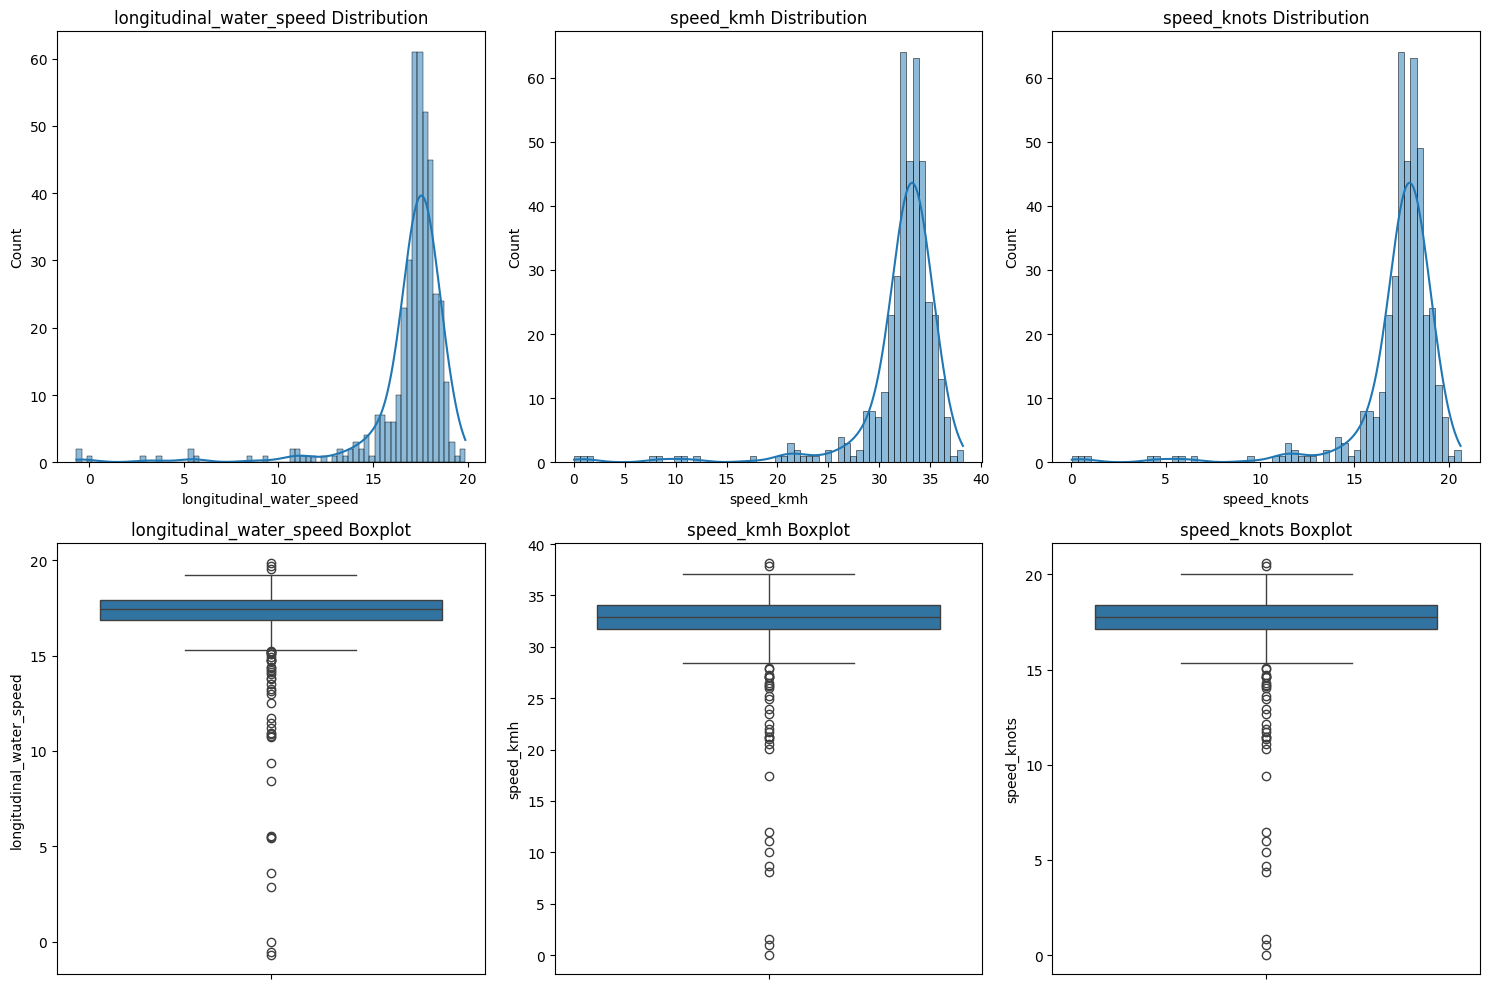

In [89]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.histplot(dataset['longitudinal_water_speed'], kde=True)
plt.title('longitudinal_water_speed Distribution')

plt.subplot(2, 3, 2)
sns.histplot(dataset['speed_kmh'], kde=True)
plt.title('speed_kmh Distribution')

plt.subplot(2, 3, 3)
sns.histplot(dataset['speed_knots'], kde=True)
plt.title('speed_knots Distribution')

plt.subplot(2, 3, 4)
sns.boxplot(y=dataset['longitudinal_water_speed'])
plt.title('longitudinal_water_speed Boxplot')

plt.subplot(2, 3, 5)
sns.boxplot(y=dataset['speed_kmh'])
plt.title('speed_kmh Boxplot')

plt.subplot(2, 3, 6)
sns.boxplot(y=dataset['speed_knots'])
plt.title('speed_knots Boxplot')

plt.tight_layout()
plt.show()

### Pitch and Rudder
Both port and starboard pitch are skewed, whereas rudder are normally distributed.

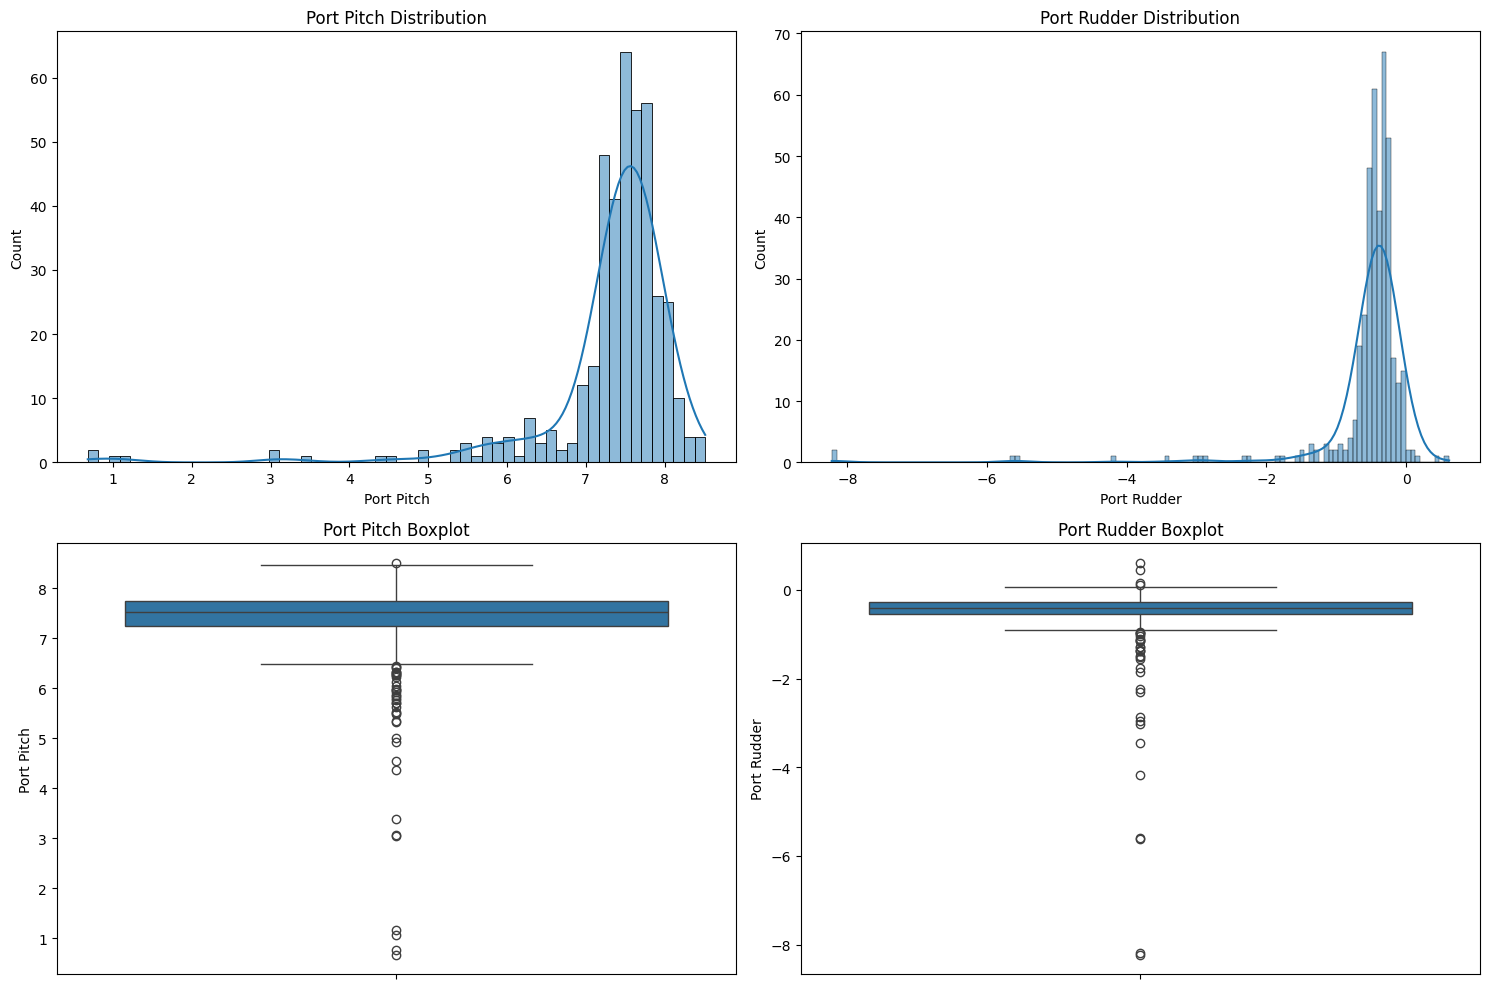

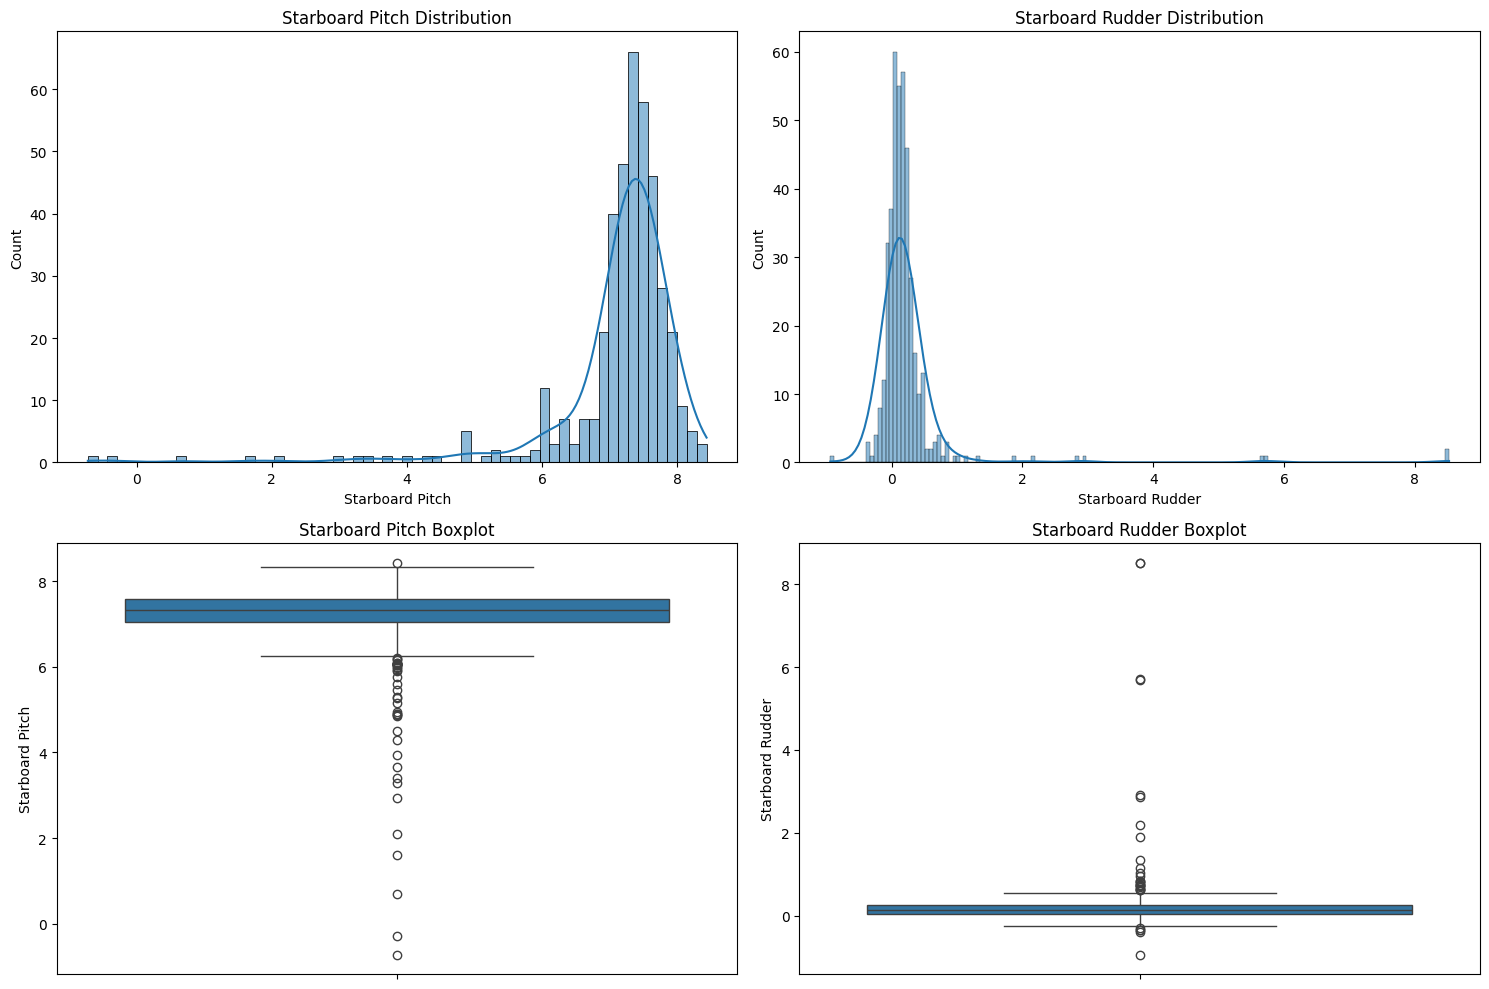

In [90]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(dataset['port_pitch'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Port Pitch Distribution')
axes[0, 0].set_xlabel('Port Pitch')

sns.histplot(dataset['port_rudder'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Port Rudder Distribution')
axes[0, 1].set_xlabel('Port Rudder')

sns.boxplot(y=dataset['port_pitch'], ax=axes[1, 0])
axes[1, 0].set_title('Port Pitch Boxplot')
axes[1, 0].set_ylabel('Port Pitch')

sns.boxplot(y=dataset['port_rudder'], ax=axes[1, 1])
axes[1, 1].set_title('Port Rudder Boxplot')
axes[1, 1].set_ylabel('Port Rudder')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(dataset['starboard_pitch'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Starboard Pitch Distribution')
axes[0, 0].set_xlabel('Starboard Pitch')

sns.histplot(dataset['starboard_rudder'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Starboard Rudder Distribution')
axes[0, 1].set_xlabel('Starboard Rudder')

sns.boxplot(y=dataset['starboard_pitch'], ax=axes[1, 0])
axes[1, 0].set_title('Starboard Pitch Boxplot')
axes[1, 0].set_ylabel('Starboard Pitch')

sns.boxplot(y=dataset['starboard_rudder'], ax=axes[1, 1])
axes[1, 1].set_title('Starboard Rudder Boxplot')
axes[1, 1].set_ylabel('Starboard Rudder')

plt.tight_layout()
plt.show()

### Tracking Data

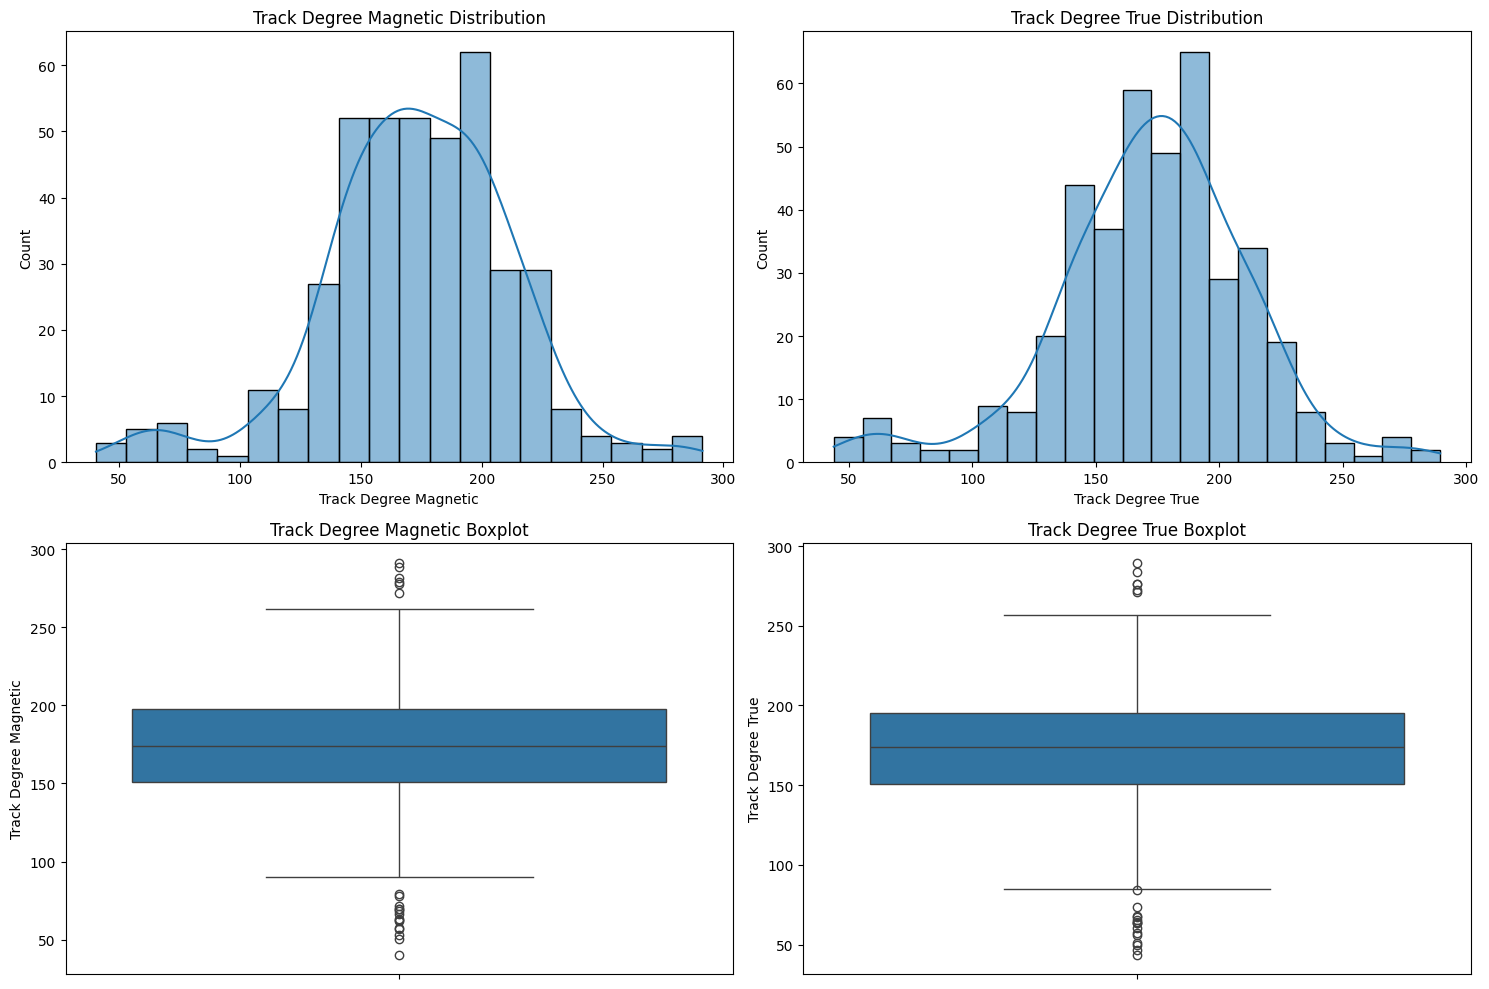

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(dataset['track_degree_magnetic'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Track Degree Magnetic Distribution')
axes[0, 0].set_xlabel('Track Degree Magnetic')

sns.histplot(dataset['track_degree_true'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Track Degree True Distribution')
axes[0, 1].set_xlabel('Track Degree True')

sns.boxplot(y=dataset['track_degree_magnetic'], ax=axes[1, 0])
axes[1, 0].set_title('Track Degree Magnetic Boxplot')
axes[1, 0].set_ylabel('Track Degree Magnetic')

sns.boxplot(y=dataset['track_degree_true'], ax=axes[1, 1])
axes[1, 1].set_title('Track Degree True Boxplot')
axes[1, 1].set_ylabel('Track Degree True')

plt.tight_layout()
plt.show()

### Wind Speed and Angle

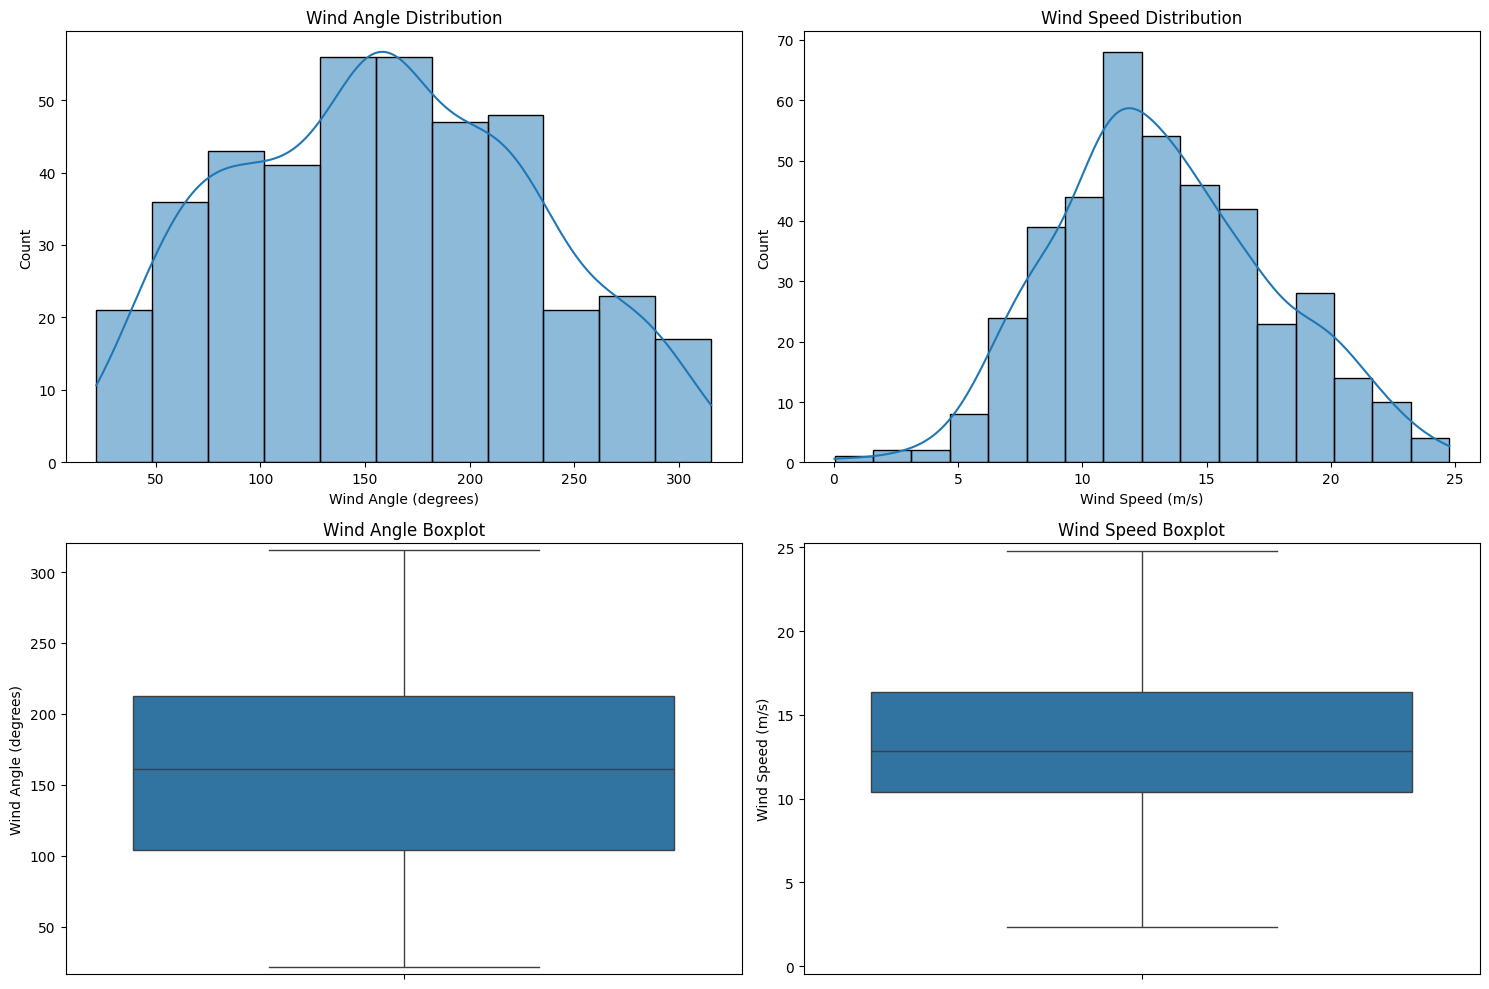

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(dataset['wind_angle'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Wind Angle Distribution')
axes[0, 0].set_xlabel('Wind Angle (degrees)')

sns.histplot(dataset['wind_speed'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Wind Speed Distribution')
axes[0, 1].set_xlabel('Wind Speed (m/s)')

sns.boxplot(y=dataset['wind_angle'], ax=axes[1, 0], showfliers=False) #Remove outliers
axes[1, 0].set_title('Wind Angle Boxplot')
axes[1, 0].set_ylabel('Wind Angle (degrees)')
axes[1, 0].set_ylim(dataset['wind_angle'].min() - 5, dataset['wind_angle'].max() + 5) #Adjust y-axis limits for better visualization

sns.boxplot(y=dataset['wind_speed'], ax=axes[1, 1], showfliers=False) #Remove outliers
axes[1, 1].set_title('Wind Speed Boxplot')
axes[1, 1].set_ylabel('Wind Speed (m/s)')
axes[1, 1].set_ylim(dataset['wind_speed'].min() - 0.5, dataset['wind_speed'].max() + 0.5) #Adjust y-axis limits for better visualization

plt.tight_layout()
plt.show()

### Data Preprocessing

In [93]:
X = dataset.drop(['EC', 'Timestamp'], axis=1)
y = dataset['EC']

imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_imputed, test_size=0.2, random_state=42)

### Models

In [94]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

In [101]:
results = {}


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = {"MSE": mse, "r2_score": r2}


model_names = list(results.keys())
MSE = [results[model]['MSE'] for model in model_names]
r2_scores = [results[model]['r2_score'] for model in model_names]

df_models = pd.DataFrame({
    'Model': model_names,
    'MSE': MSE,
    'R^2 Score': r2_scores
})

print(df_models)


               Model           MSE  R^2 Score
0      Random Forest  8.672407e-07   0.985514
1  Linear Regression  1.631705e-09   0.999973
2      Decision Tree  1.348272e-06   0.977479


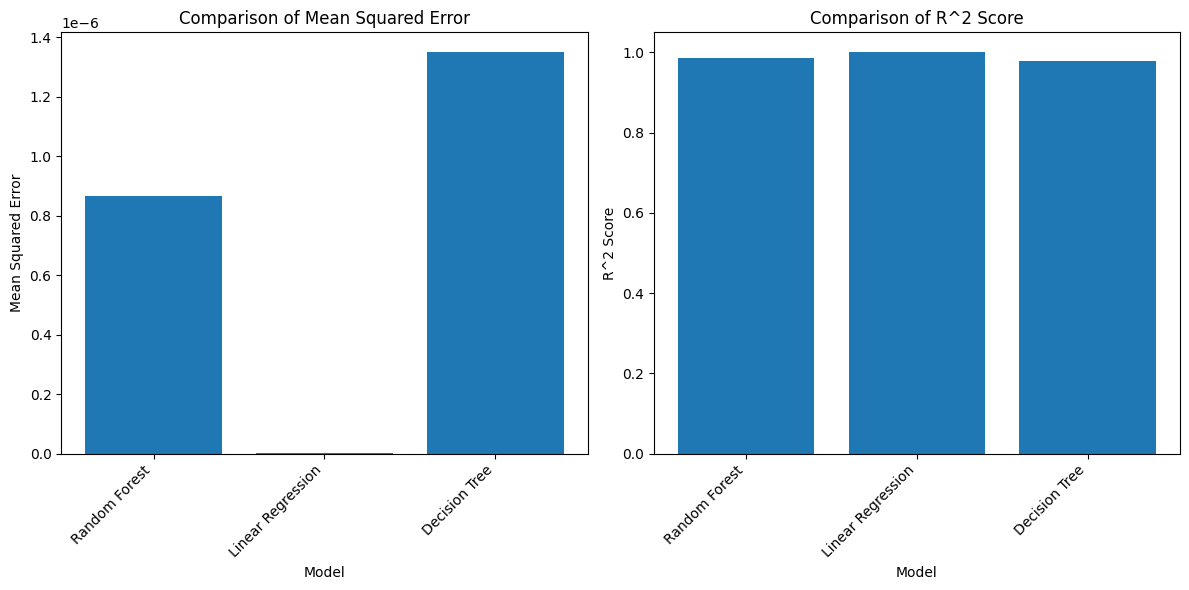

In [103]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(df_models['Model'], df_models['MSE'])
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of Mean Squared Error')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.bar(df_models['Model'], df_models['R^2 Score'])
plt.xlabel('Model')
plt.ylabel('R^2 Score')
plt.title('Comparison of R^2 Score')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Test

In [111]:
all_metrics = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    metrics = {
        'Model': name,
        'Mean Squared Error': mean_squared_error(y_test, y_pred),
        'Mean Absolute Error': mean_absolute_error(y_test, y_pred),
        'R^2 Score': r2_score(y_test, y_pred),
    }

    all_metrics.append(metrics)


df_all_metrics = pd.DataFrame(all_metrics)
print(df_all_metrics)

               Model  Mean Squared Error  Mean Absolute Error  R^2 Score
0      Random Forest        8.672407e-07             0.000288   0.985514
1  Linear Regression        1.631705e-09             0.000030   0.999973
2      Decision Tree        1.348272e-06             0.000392   0.977479
